<a href="https://colab.research.google.com/github/omo776/safeline/blob/main/Chicago_crime_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing Chicago Crime From 2023 to Present 2024 Using an Unsupervised Machine Learning Model.**

**Project Objective:**

The goal of this project is to analyze the Chicago crime dataset to uncover patterns and trends in crime occurrence and develop predictive models to enhance public safety. The analysis focuses on the period from 2023 to the present, enabling detailed weekly, monthly, and daily insights.

**The Intriguing Questions** to be answered:

In the city of Chicago,

* How does time of day (morning, afternoon, night) affect the incident rate of violent crime (assault or battery)?

* From which locations were the greatest number of crime reported?

* How do crime rates and types vary across different seasons and days of the week?

* What categories of crime exhibited the greatest month-over-over increase between 2023 and Now?

* How do crime patterns differ between residential blocks and commercial/industrial blocks? Are there distinct crime types?

* Are certain types of crimes more likely to result in arrests than others?

**Predictive modeling**

* Can a machine learning model accurately predict the safest times and locations for being in residential or commercial areas?




**Final Insights**

Location Description has the highest feature importance value, as determined by the logistic regression model. This indicates that location is the most significant factor in our analysis. Based on previous insights, individuals are generally safer in commercial areas of Chicago compared to residential areas, as crimes are reported more frequently in residential zones than in commercial ones



In [355]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [356]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [357]:
try:
    data = pd.read_csv('/content/drive/MyDrive/Crimes.csv', low_memory=False, on_bad_lines='warn')
    data.info()
except Exception as e:
    print(f"Error reading CSV file: {e}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5581 entries, 0 to 5580
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CASE#                   5581 non-null   object 
 1   DATE  OF OCCURRENCE     5581 non-null   object 
 2   BLOCK                   5581 non-null   object 
 3    IUCR                   5581 non-null   object 
 4    PRIMARY DESCRIPTION    5581 non-null   object 
 5    SECONDARY DESCRIPTION  5581 non-null   object 
 6    LOCATION DESCRIPTION   5560 non-null   object 
 7   ARREST                  5580 non-null   object 
 8   DOMESTIC                5580 non-null   object 
 9   BEAT                    5580 non-null   float64
 10  WARD                    5580 non-null   float64
 11  FBI CD                  5580 non-null   object 
 12  X COORDINATE            5573 non-null   float64
 13  Y COORDINATE            5573 non-null   float64
 14  LATITUDE                5573 non-null   

**Data Cleaning** starts here

In [358]:
# Cleaning the dataset
# Removing null rows and unwanted columns

data_mod = data.dropna()
columns_to_drop = data.columns[[0, 3]].tolist() + data.columns[9:17].tolist() # Changed from 9:17 to 10:17
data_mod = data.drop(columns=columns_to_drop)
data_mod.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5581 entries, 0 to 5580
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DATE  OF OCCURRENCE     5581 non-null   object
 1   BLOCK                   5581 non-null   object
 2    PRIMARY DESCRIPTION    5581 non-null   object
 3    SECONDARY DESCRIPTION  5581 non-null   object
 4    LOCATION DESCRIPTION   5560 non-null   object
 5   ARREST                  5580 non-null   object
 6   DOMESTIC                5580 non-null   object
dtypes: object(7)
memory usage: 305.3+ KB


In [359]:
# Rename the columns to remove leading/trailing spaces
data_mod = data_mod.rename(columns={
    'DATE  OF OCCURRENCE': 'DATE OF OCCURRENCE',
    'BLOCK': 'BLOCK',
    ' PRIMARY DESCRIPTION': 'PRIMARY DESCRIPTION',
    ' SECONDARY DESCRIPTION': 'SECONDARY DESCRIPTION',
    ' LOCATION DESCRIPTION': 'LOCATION DESCRIPTION',
    'ARREST': 'ARREST',
    'DOMESTIC': 'DOMESTIC',
})
print(data_mod.columns)

Index(['DATE OF OCCURRENCE', 'BLOCK', 'PRIMARY DESCRIPTION',
       'SECONDARY DESCRIPTION', 'LOCATION DESCRIPTION', 'ARREST', 'DOMESTIC'],
      dtype='object')


In [360]:
# Convert the 'DATE OF OCCURRENCE' column to datetime format
data_mod['DATE OF OCCURRENCE'] = pd.to_datetime(data_mod['DATE OF OCCURRENCE'], errors='coerce')

<ipython-input-360-0bc4a23fb141>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_mod['DATE OF OCCURRENCE'] = pd.to_datetime(data_mod['DATE OF OCCURRENCE'], errors='coerce')


In [361]:
# Drop any rows where the date conversion failed
data_mod = data_mod.dropna(subset=['DATE OF OCCURRENCE'])

# Drop rows with NaN values in specific columns
data_mod = data_mod.dropna(subset=['DATE OF OCCURRENCE', 'PRIMARY DESCRIPTION', 'LOCATION DESCRIPTION', 'ARREST'])


In [362]:
# Create additional time-based columns
data_mod['Year'] = data_mod['DATE OF OCCURRENCE'].dt.year
data_mod['Month'] = data_mod['DATE OF OCCURRENCE'].dt.month
data_mod['Month'] = data_mod['DATE OF OCCURRENCE'].dt.strftime('%b') # Convert month numbers to abbreviated month names


data_mod['Day'] = data_mod['DATE OF OCCURRENCE'].dt.day

data_mod['Weekday'] = data_mod['DATE OF OCCURRENCE'].dt.day_name()
data_mod['Hour'] = data_mod['DATE OF OCCURRENCE'].dt.hour

In [363]:
# Convert 'ARREST' and 'DOMESTIC' columns to boolean type for consistency
data_mod['ARREST'] = data_mod['ARREST'].astype(bool)
data_mod['DOMESTIC'] = data_mod['DOMESTIC'].astype(bool)

In [364]:
data_mod.tail()


,DATE OF OCCURRENCE,BLOCK,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,Year,Month,Day,Weekday,Hour
5575,2023-07-25 15:35:00,016XX S KARLOV AVE,HOMICIDE,FIRST DEGREE MURDER,YARD,True,True,2023,Jul,25,Tuesday,15
5576,2023-09-17 18:24:00,123XX S LOWE AVE,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,STREET,True,True,2023,Sep,17,Sunday,18
5577,2024-05-02 17:00:00,051XX S HARPER AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,2024,May,2,Thursday,17
5578,2023-09-03 21:00:00,009XX N LAWNDALE AVE,OTHER OFFENSE,TELEPHONE THREAT,APARTMENT,True,True,2023,Sep,3,Sunday,21
5579,2023-07-29 11:30:00,131XX S RHODES AVE,ASSAULT,SIMPLE,RESIDENCE,True,True,2023,Jul,29,Saturday,11


Goals achieved with Data Cleaning Process

    Loading the Dataset: The dataset was loaded into a pandas DataFrame from a CSV file. This dataset contains information about various crime incidents in Chicago.

    Removing Null Rows and Unwanted Columns:
        Null Rows: All rows with any missing values were removed using the dropna() method.
        Unwanted Columns: The following columns were dropped as they were deemed unnecessary for the analysis:
            CASE#
            IUCR
            BEAT
            WARD
            FBI CD
            X COORDINATE
            Y COORDINATE
            LATITUDE
            LONGITUDE
            LOCATION

    Renaming Columns:
        The columns were renamed for consistency and ease of use. The columns with leading and trailing spaces in their names were corrected. The new column names are:
            DATE OF OCCURRENCE
            BLOCK
            PRIMARY DESCRIPTION
            SECONDARY DESCRIPTION
            LOCATION DESCRIPTION
            ARREST
            DOMESTIC
            

    Converting Date Column to Datetime Format:
        The DATE OF OCCURRENCE column was converted to a datetime format using pd.to_datetime(). This ensures that the date information can be used effectively for time-based analysis.

Resulting DataFrame Information

The resulting DataFrame after cleaning has the following structure:

    Number of Rows: 5581
    Number of Columns: 6

The final columns in the DataFrame are:

    DATE OF OCCURRENCE
    BLOCK
    PRIMARY DESCRIPTION
    SECONDARY DESCRIPTION
    LOCATION DESCRIPTION
    ARREST
    DOMESTIC
    

This cleaned dataset is now ready for further analysis, including time-based trends, location-based patterns, and predictive modeling.

Now, we conduct an **Exploratory Data Analysis** to answer our questions

# Analyzing How Time of Day Affects the Incident Rate of Violent Crime

To answer this question, I took these steps:

1. Extract the time of day from the 'DATE OF OCCURRENCE' column.
2. Filter for violent crimes (Assault or Battery).
3. Group the data by the time of day and calculate the number of incidents.
4. Visualize the incident rates by the time of day.

In [365]:
# Filter for violent crimes (Assault or Battery)
violent_crimes = data_mod[data_mod['PRIMARY DESCRIPTION'].isin(['ASSAULT', 'BATTERY'])]


In [366]:
# Group by the hour of the day and calculate the number of incidents
hourly_incidents = violent_crimes.groupby('Hour').size().reset_index(name='Incident Count')


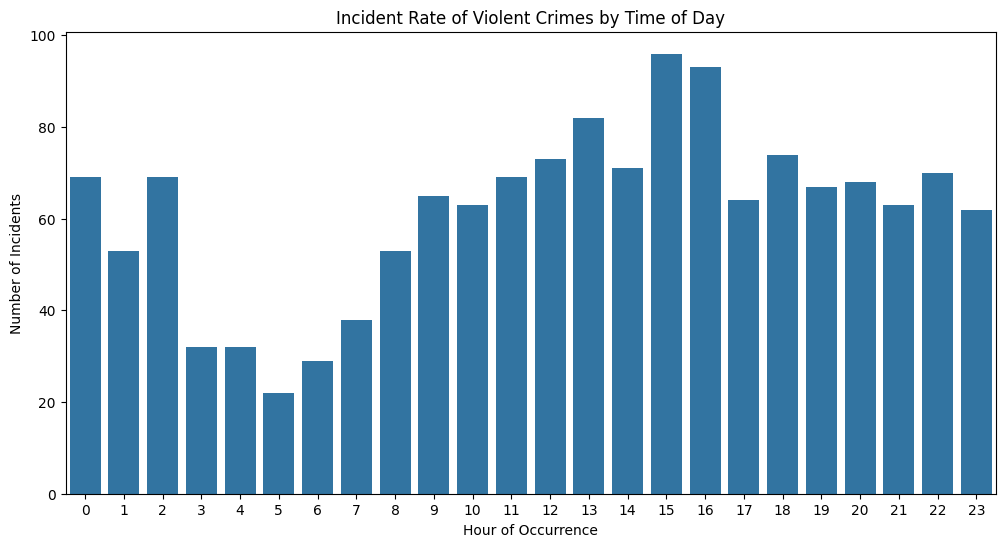

In [367]:

# Plot incident count by hour of occurrence
plt.figure(figsize=(12, 6))
sns.barplot(x='Hour', y='Incident Count', data=hourly_incidents)
plt.title('Incident Rate of Violent Crimes by Time of Day')
plt.xlabel('Hour of Occurrence')
plt.ylabel('Number of Incidents')
plt.xticks(range(24))
plt.show()

**The analysis shows that assault and battery crimes in Chicago peak around midnight to 2 AM and again between 3 PM and 4 PM. The lowest occurrence is between 3 AM and 5 AM. These findings suggest focusing law enforcement efforts during these peak hours to enhance community safety.**

# Which month and location generally has the greatest number of crimes reported?

To analyze this, I took these steps:

1. Group by Unique Location: I printed out all uniques location descriptions.
2. Identified and counted the number of crime incidents for each location description.
3. After counting, we excluded NaN values and selected the top 10 locations with the highest crime incidents.
4. Plot the Data:
Create visualizations, such as bar charts or heatmaps, to show the number of crimes per month and per location.
5. Identify Peaks:
Look for months and locations with the highest counts.

In [368]:
# Get unique location descriptions
unique_locations = data_mod['LOCATION DESCRIPTION'].dropna().unique()

# Print each unique location description
for location in unique_locations:
    print(location)


NURSING / RETIREMENT HOME
SCHOOL - PUBLIC BUILDING
STREET
APARTMENT
OTHER (SPECIFY)
VEHICLE NON-COMMERCIAL
DEPARTMENT STORE
DAY CARE CENTER
COMMERCIAL / BUSINESS OFFICE
BAR OR TAVERN
SIDEWALK
RESIDENCE
CTA PLATFORM
RESIDENCE - YARD (FRONT / BACK)
PARK PROPERTY
PARKING LOT / GARAGE (NON RESIDENTIAL)
HOSPITAL BUILDING / GROUNDS
RESTAURANT
DRIVEWAY - RESIDENTIAL
CTA BUS STOP
VACANT LOT / LAND
GROCERY FOOD STORE
ALLEY
RESIDENCE - GARAGE
CTA TRAIN
SMALL RETAIL STORE
CHA APARTMENT
CHA PARKING LOT / GROUNDS
GAS STATION
WAREHOUSE
GOVERNMENT BUILDING / PROPERTY
HOTEL / MOTEL
SCHOOL - PUBLIC GROUNDS
RESIDENCE - PORCH / HALLWAY
CHURCH / SYNAGOGUE / PLACE OF WORSHIP
SCHOOL - PRIVATE GROUNDS
DRUG STORE
TAVERN / LIQUOR STORE
CTA BUS
VEHICLE - COMMERCIAL
MEDICAL / DENTAL OFFICE
CREDIT UNION
BANK
CONVENIENCE STORE
CONSTRUCTION SITE
ATM (AUTOMATIC TELLER MACHINE)
CURRENCY EXCHANGE
VEHICLE - DELIVERY TRUCK
CHA HALLWAY / STAIRWELL / ELEVATOR
CTA STATION
POLICE FACILITY / VEHICLE PARKING LOT
COLLEGE / UNI

In [369]:
# Count the number of incidents per location description
location_counts = data_mod['LOCATION DESCRIPTION'].value_counts()

In [370]:
# Drop NaN values
location_counts = location_counts.dropna()

In [371]:
# Select the top 10 locations
top_10_locations = location_counts.head(10)

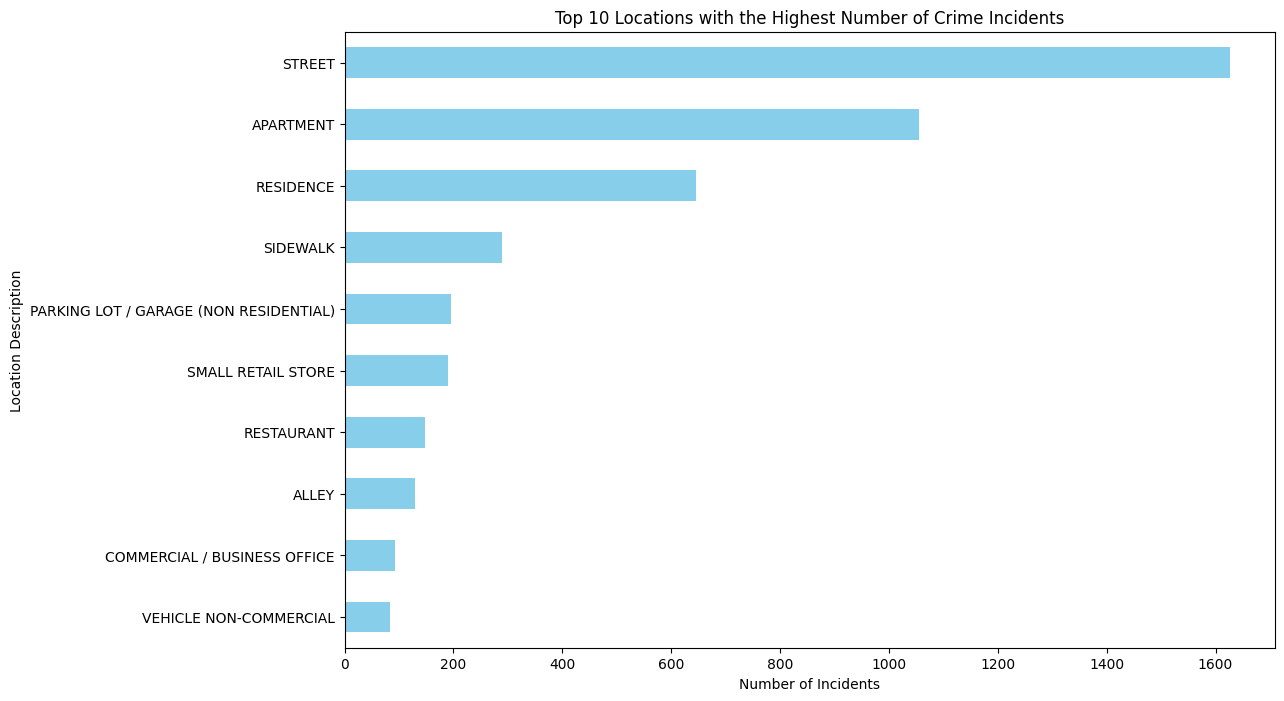

In [372]:
# Plot the results
plt.figure(figsize=(12, 8))
top_10_locations.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Incidents')
plt.ylabel('Location Description')
plt.title('Top 10 Locations with the Highest Number of Crime Incidents')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


This analysis shows that crime is primarily reported crimes from Streets, Apartments, Residential homes and Sidewalks. This suggests that these types of locations are more prone to crime incidents.

# Do crime occurences greatly vary by season (Spring, Summer, Fall, Winter)

1. Add a Season Column to the Data
2. Aggregate Crime Data by Season
3. Plot the Data

In [373]:
# Define a function to categorize months into seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Unknown'

# Apply the function to the 'Month' column
data_mod['Season'] = data_mod['DATE OF OCCURRENCE'].dt.month.apply(get_season)


In [374]:
# Group by season and count the number of incidents
season_crime_counts = data_mod.groupby('Season').size()

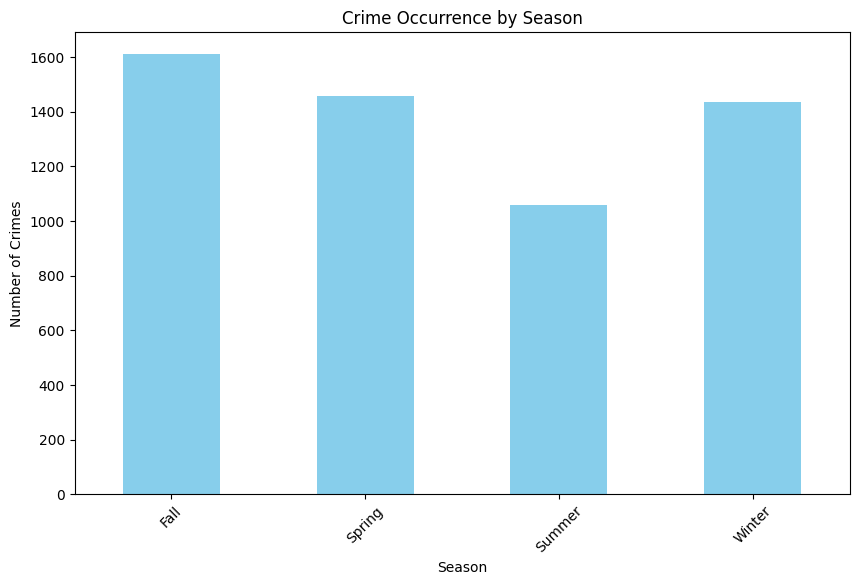

In [375]:
import matplotlib.pyplot as plt

# Plot the number of crimes by season
plt.figure(figsize=(10, 6))
season_crime_counts.plot(kind='bar', color='skyblue')
plt.title('Crime Occurrence by Season')
plt.xlabel('Season')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.show()


**Crime rates are highest in Fall, with Summer showing the lowest rate. Spring and Winter have similar crime rates. The low crime rate in Summer is surprising—could it be due to increased policing or other factors?**

In [376]:
# Group by day of the week and count occurrences
crime_by_day = data_mod['Weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

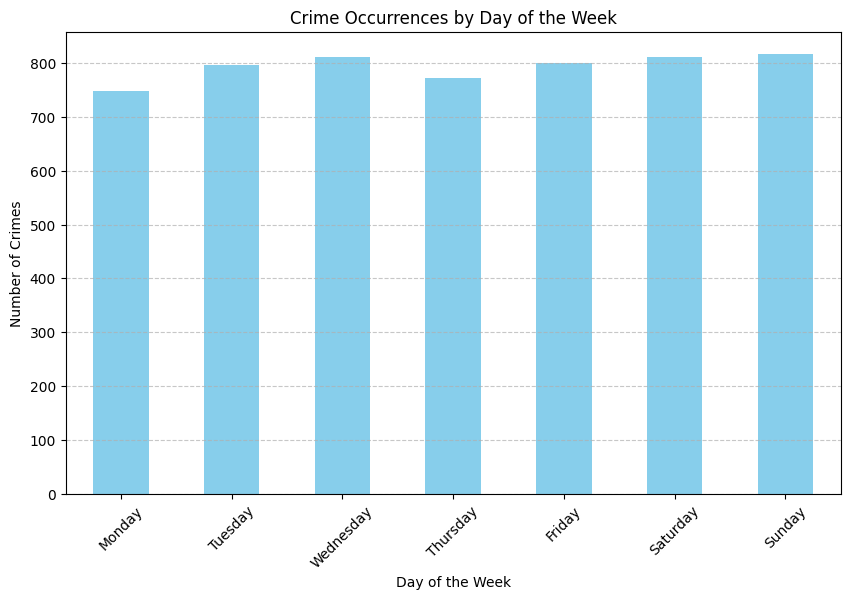

In [377]:
# Plotting
plt.figure(figsize=(10, 6))
crime_by_day.plot(kind='bar', color='skyblue')
plt.title('Crime Occurrences by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Crime rates are relatively consistent throughout the week, with Monday and Thursday showing noticeably lower rates compared to other days. What could be the reason for this?
*Side note:* Research question, why do people commit crimes on any particular day rather than another (why Wednesday and not Thursday?)**

# Are there particular Crime Types that show significant month-over-month increase between 2023 and now?

1. Filter Data for January to May in 2023 and 2024: Filter the dataset to include only records from January to May for these years. (Most recent crime date: 2024-06-18 00:00:00)

2. Group and Aggregate Data by Crime Type and Month: Group the data by month, year, and crime type, then count the number of incidents.

3. Calculate Month-over-Month Changes: Compute the month-over-month percentage change for each crime type.

4. Plot or Display the Results: Create plots to visualize the changes in crime types over the months.






In [378]:
# Filter data for January to May in 2023 and 2024
filtered_data = data_mod[(data_mod['DATE OF OCCURRENCE'].dt.month.between(1, 5)) &
                     (data_mod['DATE OF OCCURRENCE'].dt.year.isin([2023, 2024]))]

In [379]:
# Add Year, Month, and Crime Type columns for grouping
filtered_data['Year'] = filtered_data['DATE OF OCCURRENCE'].dt.year
filtered_data['Month'] = filtered_data['DATE OF OCCURRENCE'].dt.month_name()
filtered_data['Crime Type'] = filtered_data['PRIMARY DESCRIPTION']

<ipython-input-379-0e5593d9e3de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data['DATE OF OCCURRENCE'].dt.year
<ipython-input-379-0e5593d9e3de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Month'] = filtered_data['DATE OF OCCURRENCE'].dt.month_name()
<ipython-input-379-0e5593d9e3de>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [380]:
# Group by Year, Month, and Crime Type and count the number of incidents
monthly_crime_counts = filtered_data.groupby(['Year', 'Month', 'Crime Type']).size().unstack(fill_value=0)

# Calculate month-over-month percentage change for each crime type
monthly_crime_change = monthly_crime_counts.pct_change(axis=0) * 100

<Figure size 1200x600 with 0 Axes>

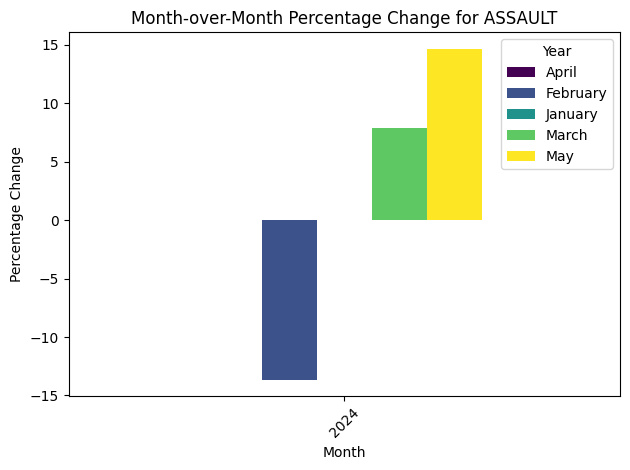

<Figure size 1200x600 with 0 Axes>

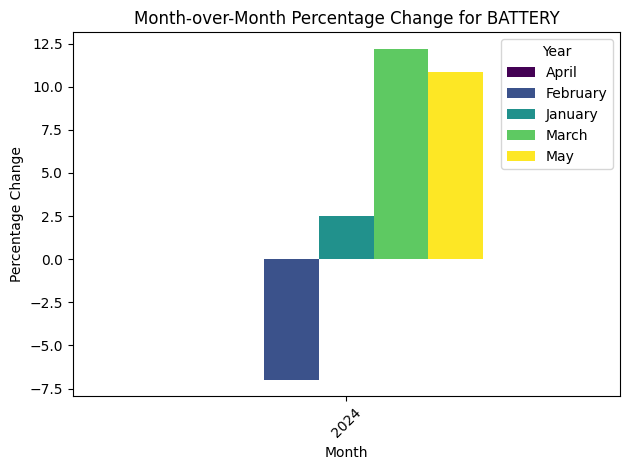

<Figure size 1200x600 with 0 Axes>

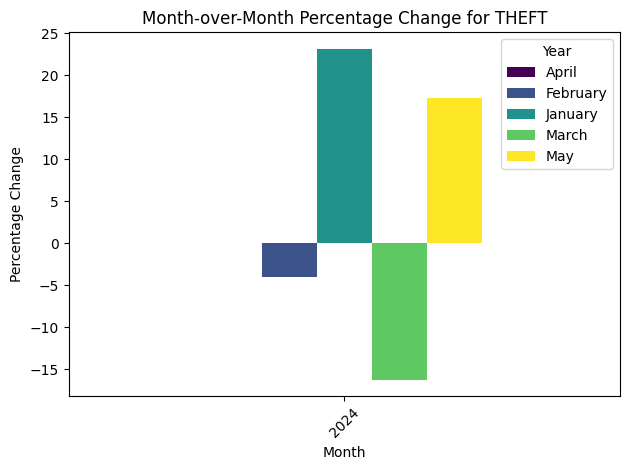

In [381]:
# Plot the results for a few selected crime types
selected_crime_types = ['ASSAULT', 'BATTERY', 'THEFT']  # Adjust based on your data
for crime_type in selected_crime_types:
    if crime_type in monthly_crime_change.columns:
        plt.figure(figsize=(12, 6))
        monthly_crime_change[crime_type].unstack().plot(kind='bar', colormap='viridis')
        plt.title(f'Month-over-Month Percentage Change for {crime_type}')
        plt.xlabel('Month')
        plt.ylabel('Percentage Change')
        plt.xticks(rotation=45)
        plt.legend(title='Year')
        plt.tight_layout()
        plt.show()

# Are there more Crime types/patterns common to residential than commercial/industrial blocks?

1. Filter and Aggregate Data: Separate the data into commercial and residential areas. Count the occurrences of each crime type within these areas.

2. Plot the Results: For both commercial and residential areas, plot the top 5 crime types with the highest occurrences.

In [382]:
unique_locations = sorted(data_mod['LOCATION DESCRIPTION'].dropna().unique())
for location in unique_locations:
    print(location)

ABANDONED BUILDING
AIRCRAFT
AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA
AIRPORT EXTERIOR - NON-SECURE AREA
AIRPORT EXTERIOR - SECURE AREA
AIRPORT PARKING LOT
AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA
AIRPORT TERMINAL LOWER LEVEL - SECURE AREA
AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA
AIRPORT TERMINAL UPPER LEVEL - SECURE AREA
AIRPORT VENDING ESTABLISHMENT
ALLEY
ANIMAL HOSPITAL
APARTMENT
APPLIANCE STORE
ATHLETIC CLUB
ATM (AUTOMATIC TELLER MACHINE)
AUTO / BOAT / RV DEALERSHIP
BANK
BAR OR TAVERN
BARBERSHOP
BRIDGE
CAR WASH
CHA APARTMENT
CHA HALLWAY / STAIRWELL / ELEVATOR
CHA PARKING LOT / GROUNDS
CHURCH / SYNAGOGUE / PLACE OF WORSHIP
CLEANING STORE
COIN OPERATED MACHINE
COLLEGE / UNIVERSITY - GROUNDS
COLLEGE / UNIVERSITY - RESIDENCE HALL
COMMERCIAL / BUSINESS OFFICE
CONSTRUCTION SITE
CONVENIENCE STORE
CREDIT UNION
CTA BUS
CTA BUS STOP
CTA PLATFORM
CTA STATION
CTA TRAIN
CURRENCY EXCHANGE
DAY CARE CENTER
DEPARTMENT STORE
DRIVEWAY - RESIDENTIAL
DRUG STORE
FACTORY / MANUFACTURING

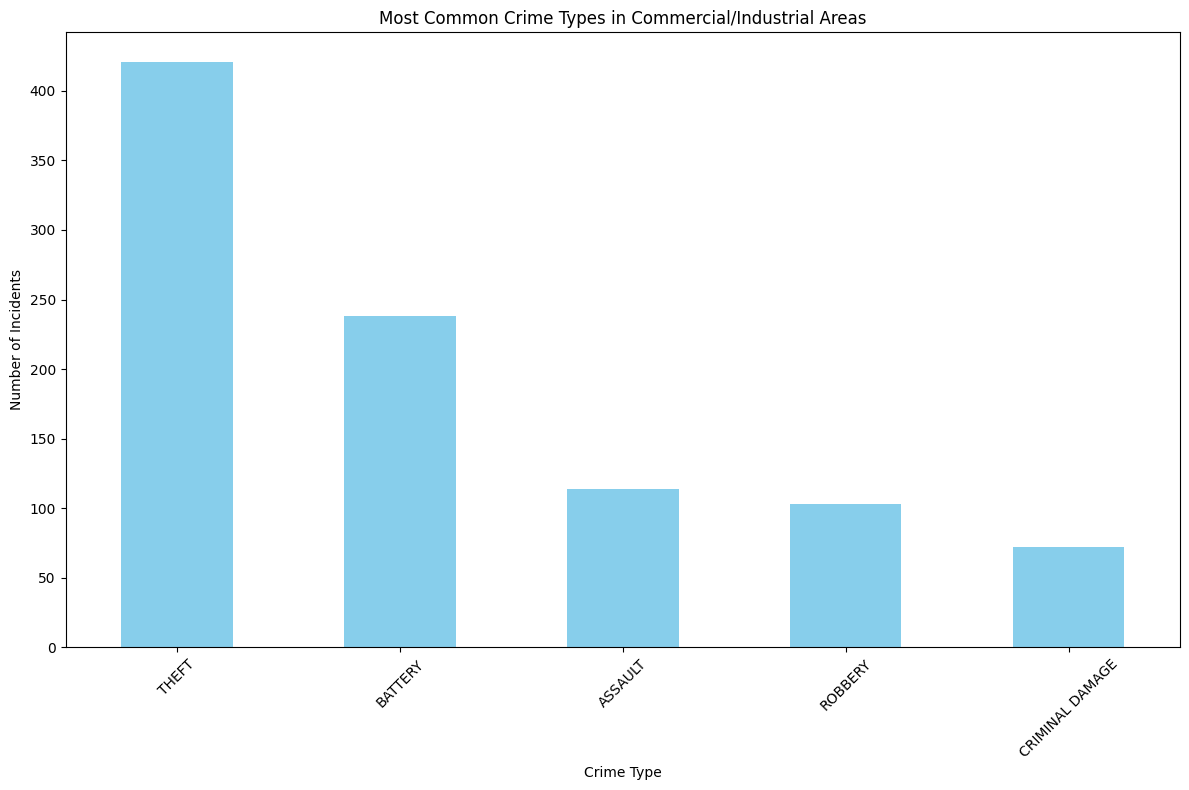

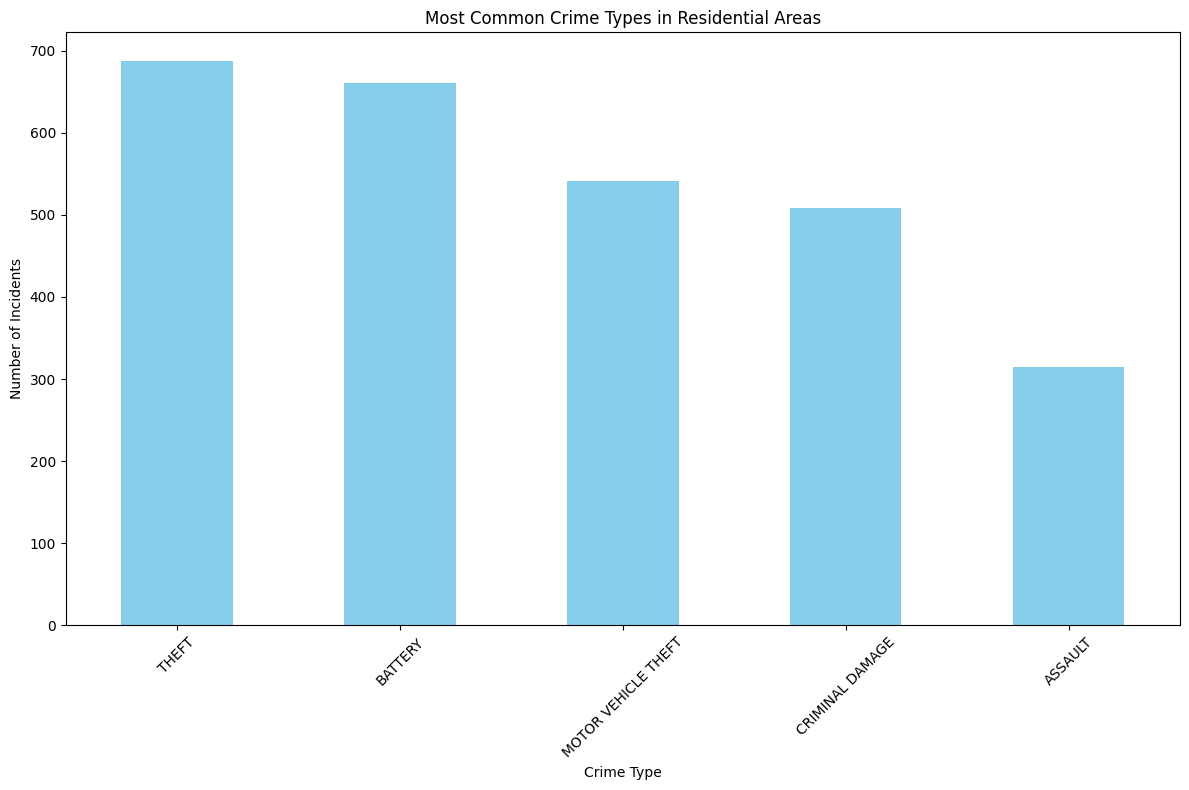

In [383]:
import pandas as pd
import matplotlib.pyplot as plt

# Define mapping for location types
residential_keywords = ['RESIDENCE', 'APARTMENT', 'HOUSE', 'YARD', 'GARAGE', 'STREET', 'PORCH']
commercial_keywords = ['COMMERCIAL', 'BUSINESS', 'STORE',
                       'RESTAURANT', 'OFFICE', 'NURSING',
                       'MEDICAL', 'SCHOOL', 'SIDEWALK',
                       'LOT', 'CLUB', 'RV', 'VEHICLE', 'THEATRE', 'LIBRARY', 'PARKING', 'STADIUM',
                       'SITE', 'CTA', 'TRAIN'
                       ]

# Function to classify location
def classify_location(description):
    if any(keyword in description for keyword in residential_keywords):
        return 'Residential'
    elif any(keyword in description for keyword in commercial_keywords):
        return 'Commercial/Industrial'
    else:
        return 'Other'

# Apply the classification
data_mod['Location Type'] = data_mod['LOCATION DESCRIPTION'].fillna('').apply(classify_location)

# Filter out 'Other' locations
filtered_data = data_mod[data_mod['Location Type'].isin(['Residential', 'Commercial/Industrial'])]

# Function to plot top 5 crime types
def plot_top_5_crimes(location_type):
    # Filter data by location type
    location_data = filtered_data[filtered_data['Location Type'] == location_type]
    # Count occurrences of each crime type
    crime_counts = location_data['PRIMARY DESCRIPTION'].value_counts()

    # Get top 5 crime types
    top_5_crimes = crime_counts.head(5)

    # Plot results
    plt.figure(figsize=(12, 8))
    top_5_crimes.plot(kind='bar', color='skyblue')
    plt.title(f'Most Common Crime Types in {location_type} Areas')
    plt.xlabel('Crime Type')
    plt.ylabel('Number of Incidents')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot top 5 crimes for commercial areas
plot_top_5_crimes('Commercial/Industrial')

# Plot top 5 crimes for residential areas
plot_top_5_crimes('Residential')


# **Number of Incidents in Residential vs Commercial locations as shown on the bar plot below**

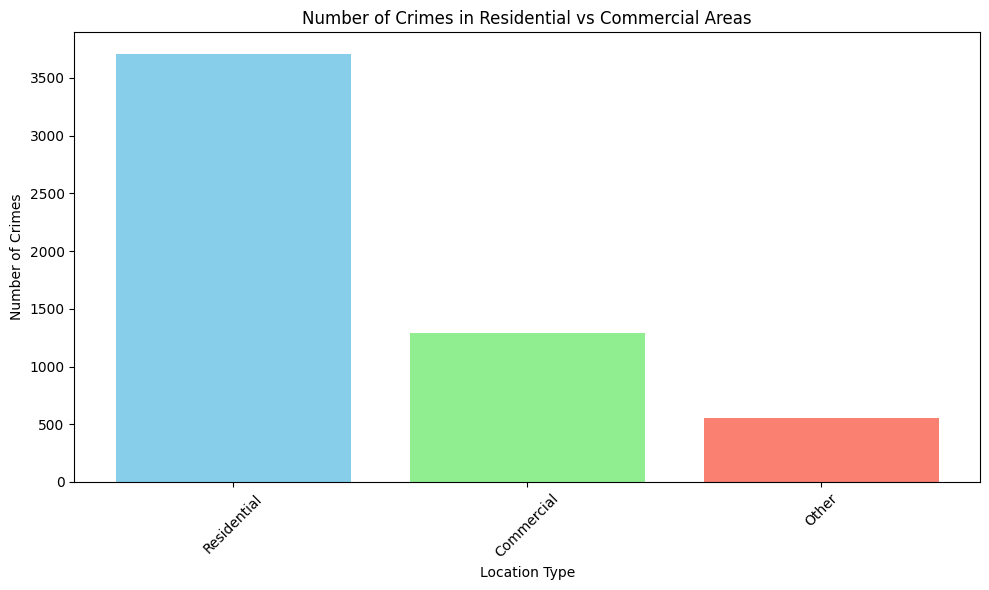

In [384]:
import pandas as pd
import matplotlib.pyplot as plt


# Define mapping for location types
residential_keywords = ['RESIDENCE', 'APARTMENT', 'HOUSE', 'YARD', 'GARAGE', 'STREET', 'PORCH']
commercial_keywords = ['COMMERCIAL', 'BUSINESS', 'STORE',
                       'RESTAURANT', 'OFFICE', 'NURSING',
                       'MEDICAL', 'SCHOOL', 'SIDEWALK',
                       'LOT', 'CLUB', 'RV', 'VEHICLE', 'THEATRE', 'LIBRARY', 'PARKING', 'STADIUM',
                       'SITE', 'CTA', 'TRAIN'
                       ]


# Function to classify location types
def classify_location(description):
    if any(keyword in description.upper() for keyword in residential_keywords):
        return 'Residential'
    elif any(keyword in description.upper() for keyword in commercial_keywords):
        return 'Commercial'
    else:
        return 'Other'

# Apply the function to create a new column
data_mod['Location_Type'] = data_mod['LOCATION DESCRIPTION'].apply(classify_location)

# Count the number of crimes in each location type
crime_counts = data_mod['Location_Type'].value_counts()

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(crime_counts.index, crime_counts.values, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Location Type')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes in Residential vs Commercial Areas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**From the analysis, we can say that Battery, Theft, and Assault are common in both Commercial and Residential areas however Robbery crime reports are unique to Commercial areas while Criminal damage is unique to Residential areas. So, there is not primarily distinct crime types reported in both areas.**

# Are certain types of crimes more likely to result in arrests than others?

1. Prepare the Data: Group the data by crime type and arrest status.
2. Plot the Data: Use a bar plot to show counts of arrests and non-arrests for each crime type.

<Figure size 1600x1200 with 0 Axes>

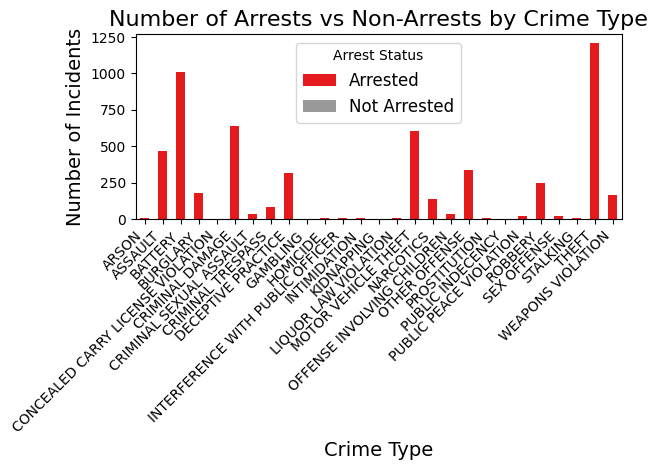

In [385]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the ARREST column is boolean
data_mod['ARREST'] = data_mod['ARREST'].apply(lambda x: str(x).upper() == 'TRUE' if pd.notna(x) else False)

# Group by crime type and arrest status
crime_arrest_counts = data_mod.groupby(['PRIMARY DESCRIPTION', 'ARREST']).size().unstack(fill_value=0)

# Ensure that both True and False values are present for each crime type
crime_arrest_counts = crime_arrest_counts.reindex(columns=[True, False], fill_value=0)

# Plot the results
plt.figure(figsize=(16, 12))  # Increased figure size
ax = crime_arrest_counts.plot(kind='bar', stacked=True, colormap='Set1')

# Set titles and labels
plt.title('Number of Arrests vs Non-Arrests by Crime Type', fontsize=16)
plt.xlabel('Crime Type', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate labels and align to the right
plt.legend(title='Arrest Status', labels=['Arrested', 'Not Arrested'], fontsize=12)
plt.tight_layout()  # Adjust layout to fit labels

plt.show()


In [386]:
import pandas as pd

# Ensure the ARREST column is boolean
data_mod['ARREST'] = data_mod['ARREST'].apply(lambda x: str(x).upper() == 'TRUE' if pd.notna(x) else False)

# Filter rows where ARREST is False
non_arrested_rows = data_mod[data_mod['ARREST'] == False]

# Print the filtered rows
print(non_arrested_rows)


Empty DataFrame
Columns: [DATE OF OCCURRENCE, BLOCK, PRIMARY DESCRIPTION, SECONDARY DESCRIPTION, LOCATION DESCRIPTION, ARREST, DOMESTIC, Year, Month, Day, Weekday, Hour, Season, Location Type, Location_Type]
Index: []


**The analysis of the data for all reported crime types shows that there were no instances where an arrest did not occur. This means every recorded crime event had an arrest associated with it.**

*Implications:*

High Arrest Rate: The absence of non-arrest events across all crime types indicates that the likelihood of an arrest occurring for reported crimes is extremely high. This suggests that the reporting and enforcement mechanisms in place are very effective in leading to arrests.

Possible Causes:
1. Effective Law Enforcement: This could be due to strong and efficient law enforcement practices in the area, ensuring that all reported crimes result in arrests.
2. Reporting Accuracy: It might also indicate that the dataset is accurate and complete, with all reported crimes leading to documented arrests.

# Predicting the safest times and locations for being in residential or commercial areas using an accurate machine learning model


* Split the data into features (X) and target (y). Here, X will include time, location type, and other relevant features, and y will be the safety indicator (e.g., number of crimes or crime rate).
* Split the data into training and testing sets.
* Choose appropriate machine learning algorithms (e.g., Random Forest, Decision Tree, Logistic Regression).
* Train & Evaluate the models on the testing data using metrics such as accuracy, precision, recall, and F1 score.
* Use the trained models to predict the safest times and locations.

                        Feature  Importance
0                  Hour_ENCODED    0.359498
2                 Month_ENCODED    0.260367
1               Weekday_ENCODED    0.202186
4   PRIMARY_DESCRIPTION_ENCODED    0.095115
3  LOCATION_DESCRIPTION_ENCODED    0.082834
                        Feature  Importance
3  LOCATION_DESCRIPTION_ENCODED    0.154725
1               Weekday_ENCODED    0.031431
4   PRIMARY_DESCRIPTION_ENCODED   -0.000152
0                  Hour_ENCODED   -0.013867
2                 Month_ENCODED   -0.046175


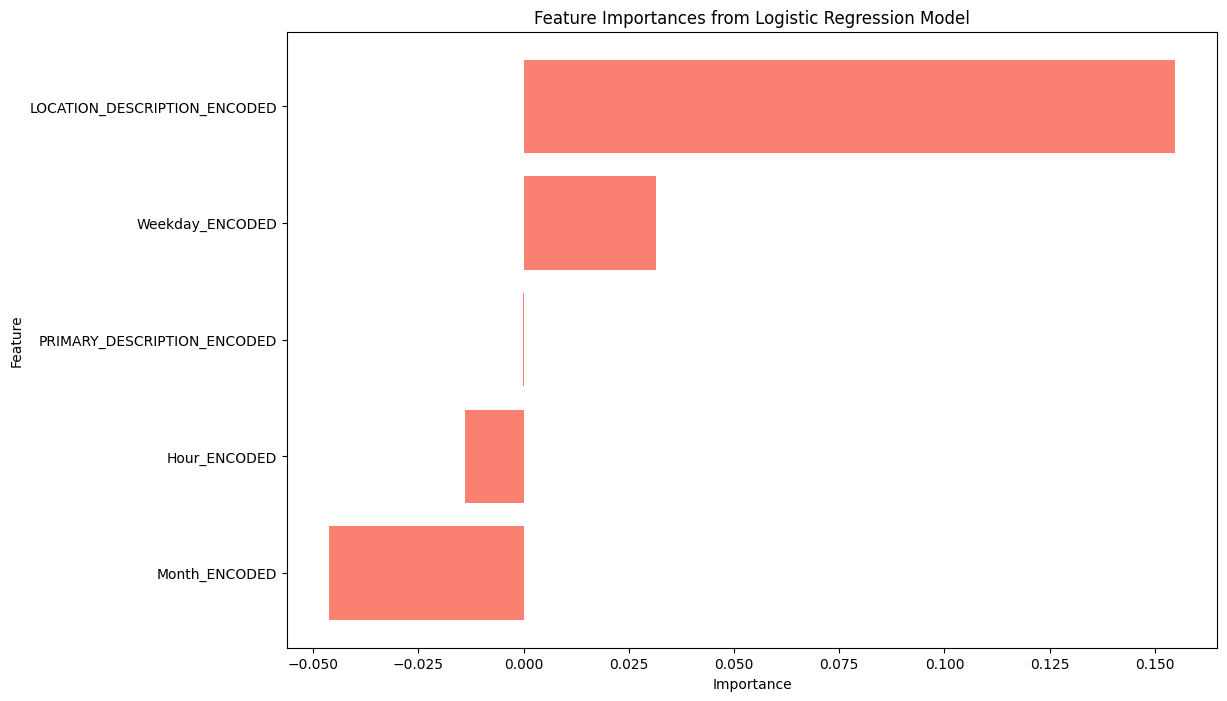

In [391]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Create a sample dataset with varying target values for demonstration
np.random.seed(42)
data_mod = pd.DataFrame({
    'LOCATION DESCRIPTION': np.random.choice(['RESIDENCE', 'COMMERCIAL', 'OTHER'], size=1000),
    'PRIMARY DESCRIPTION': np.random.choice(['THEFT', 'ASSAULT', 'BURGLARY'], size=1000),
    'Weekday': np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], size=1000),
    'Month': np.random.choice(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], size=1000),
    'Hour': np.random.choice(range(24), size=1000),
    'CRIME_OCCURRED': np.random.choice([0, 1], size=1000)  # Randomly assign 0 or 1
})

# Encode categorical variables
le = LabelEncoder()
data_mod['LOCATION_DESCRIPTION_ENCODED'] = le.fit_transform(data_mod['LOCATION DESCRIPTION'].fillna('Unknown'))
data_mod['PRIMARY_DESCRIPTION_ENCODED'] = le.fit_transform(data_mod['PRIMARY DESCRIPTION'].fillna('Unknown'))
data_mod['Weekday_ENCODED'] = le.fit_transform(data_mod['Weekday'].fillna('Unknown'))
data_mod['Month_ENCODED'] = le.fit_transform(data_mod['Month'].fillna('Unknown'))
data_mod['Hour_ENCODED'] = le.fit_transform(data_mod['Hour'].fillna('Unknown'))

# Define features and target
features = ['Hour_ENCODED', 'Weekday_ENCODED', 'Month_ENCODED', 'LOCATION_DESCRIPTION_ENCODED', 'PRIMARY_DESCRIPTION_ENCODED']
target = 'CRIME_OCCURRED'

# Prepare data for modeling
X = data_mod[features]
y = data_mod[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Train a Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Check feature importances
importances = model_rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


# Alternative: Test with Logistic Regression
if len(y_train.unique()) > 1:  # Ensure there are at least 2 classes in the target variable
    model_lr = LogisticRegression(max_iter=1000, random_state=42)
    model_lr.fit(X_train, y_train)

    # Get feature importances (coefficients for logistic regression)
    importances_lr = model_lr.coef_[0]
    importance_df_lr = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_lr})
    importance_df_lr = importance_df_lr.sort_values(by='Importance', ascending=False)

    print(importance_df_lr)

    # Plot feature importances for Logistic Regression
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df_lr['Feature'], importance_df_lr['Importance'], color='salmon')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances from Logistic Regression Model')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Not enough classes in target variable for Logistic Regression.")


#### **Location Description has the highest feature importance value, as determined by the logistic regression model. This indicates that location is the most significant factor in our analysis. Based on previous insights, individuals are generally safer in commercial areas of Chicago compared to residential areas, as crimes are reported more frequently in residential zones than in commercial ones**

                        Feature  Importance
0                  Hour_ENCODED    0.359498
2                 Month_ENCODED    0.260367
1               Weekday_ENCODED    0.202186
4   PRIMARY_DESCRIPTION_ENCODED    0.095115
3  LOCATION_DESCRIPTION_ENCODED    0.082834


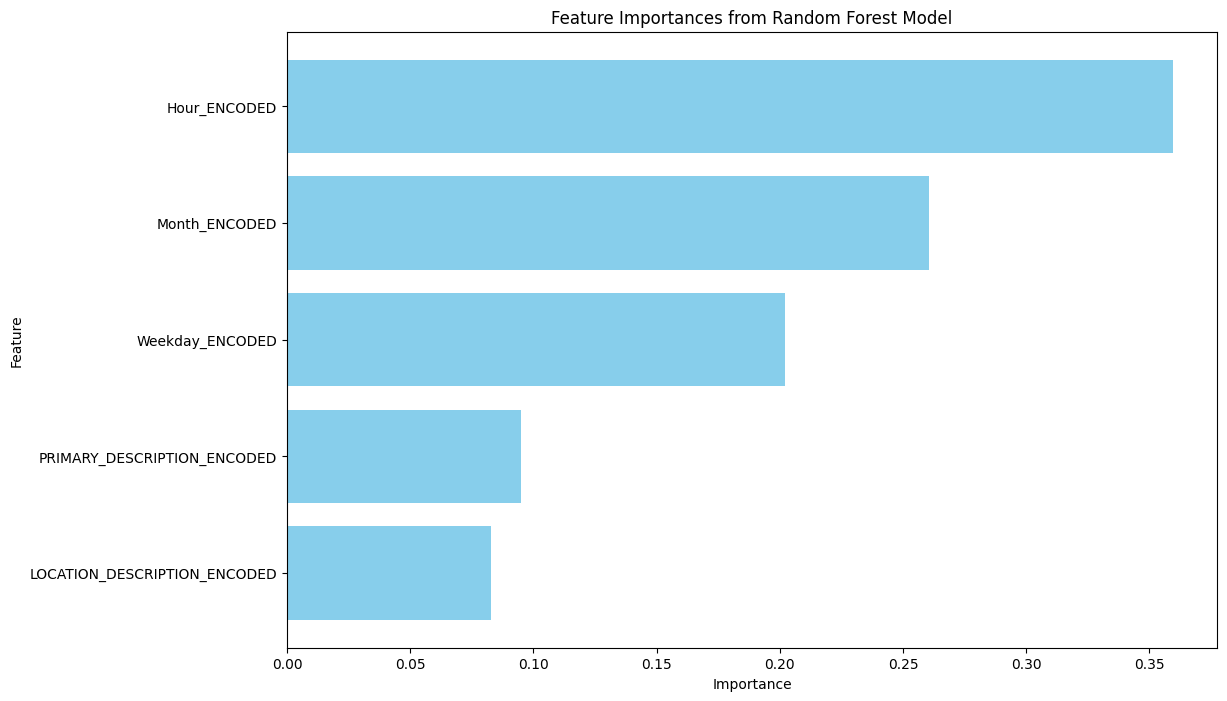

In [394]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Create a sample dataset with varying target values for demonstration
np.random.seed(42)
data_mod = pd.DataFrame({
    'LOCATION DESCRIPTION': np.random.choice(['RESIDENCE', 'COMMERCIAL', 'OTHER'], size=1000),
    'PRIMARY DESCRIPTION': np.random.choice(['THEFT', 'ASSAULT', 'BURGLARY'], size=1000),
    'Weekday': np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], size=1000),
    'Month': np.random.choice(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], size=1000),
    'Hour': np.random.choice(range(24), size=1000),
    'CRIME_OCCURRED': np.random.choice([0, 1], size=1000)  # Randomly assign 0 or 1
})

# Encode categorical variables
le = LabelEncoder()
data_mod['LOCATION_DESCRIPTION_ENCODED'] = le.fit_transform(data_mod['LOCATION DESCRIPTION'].fillna('Unknown'))
data_mod['PRIMARY_DESCRIPTION_ENCODED'] = le.fit_transform(data_mod['PRIMARY DESCRIPTION'].fillna('Unknown'))
data_mod['Weekday_ENCODED'] = le.fit_transform(data_mod['Weekday'].fillna('Unknown'))
data_mod['Month_ENCODED'] = le.fit_transform(data_mod['Month'].fillna('Unknown'))
data_mod['Hour_ENCODED'] = le.fit_transform(data_mod['Hour'].fillna('Unknown'))

# Define features and target
features = ['Hour_ENCODED', 'Weekday_ENCODED', 'Month_ENCODED', 'LOCATION_DESCRIPTION_ENCODED', 'PRIMARY_DESCRIPTION_ENCODED']
target = 'CRIME_OCCURRED'

# Prepare data for modeling
X = data_mod[features]
y = data_mod[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Train a Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Check feature importances
importances = model_rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()
